In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from pydeseq2.preprocessing import deseq2_norm_fit, deseq2_norm_transform
from umap import UMAP
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from imblearn.ensemble import BalancedRandomForestClassifier
import shap
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing

2025-02-09 21:18:32.161837: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 0. Data Loading
In this case, the gene expression count is in a CSV, and the labels (groups of cancer) are in another CSV:

In [2]:
data = pd.read_csv("data.csv", index_col = 0)
labels = pd.read_csv("labels.csv")

In [3]:
display(data.head(), labels.head())

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


## 1. Data Descriptive Analysis

In [4]:
data.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


### Balance or Unbalanced Data

/tmp/ipykernel_8774/3754227409.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


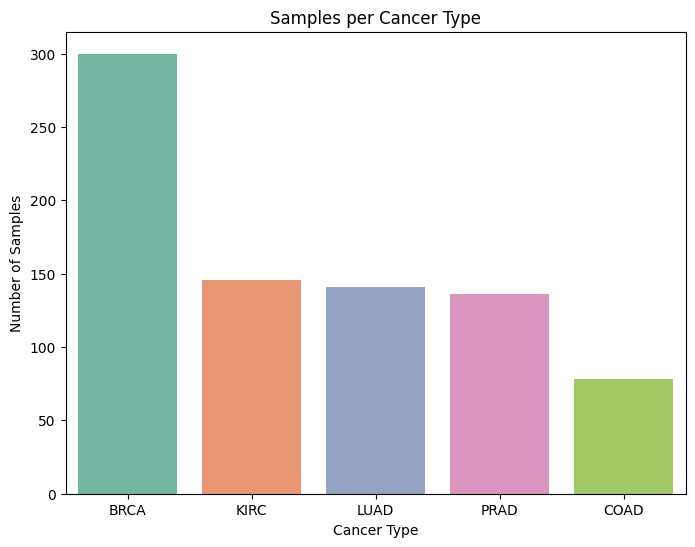

In [5]:
class_counts = labels["Class"].value_counts()
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    x=class_counts.index,
    y=class_counts.values,
    palette="Set2",
    legend="fds"
)
ax.set(xlabel = "Cancer Type", ylabel='Number of Samples', title = "Samples per Cancer Type")
plt.show()

### Gene counts Descriptive Analysis
In this type of datasets, it is important to analyse the distribution of counts per sample and counts per gene.

#### Counts per Gene

/tmp/ipykernel_8774/994592299.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(summary_stats_sorted["Total_Reads"], ax=axes[1], palette="Blues", orient="v")


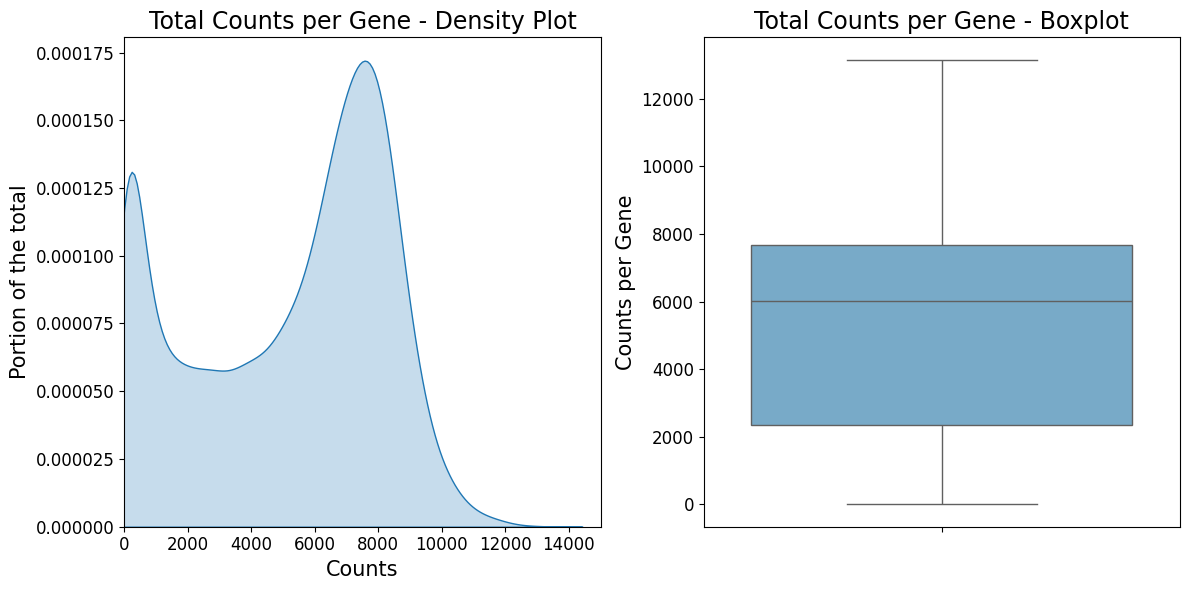

In [6]:
total_counts = data.sum(axis=0)

median_counts = data.median(axis=0)
mean_counts = data.mean(axis=0)
std_counts = data.std(axis=0)

total_counts_overall = total_counts.sum()
percent_reads_mapped = (total_counts / total_counts_overall) * 100

summary_stats = pd.DataFrame({
    "Total_Reads": total_counts,
    "Median_Reads": median_counts,
    "Mean_Reads": mean_counts,
    "Std_Dev_Reads": std_counts,
    "Percent_Reads_Mapped": percent_reads_mapped
})
summary_stats_sorted = summary_stats.sort_values(by=["Total_Reads"], axis=0, ascending=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.kdeplot(x=summary_stats_sorted["Total_Reads"], fill=True, ax=axes[0])
axes[0].set_title("Total Counts per Gene - Density Plot", fontsize=17)
axes[0].set_xlabel("Counts", fontsize=15)
axes[0].set_ylabel("Portion of the total", fontsize=15)
axes[0].set_xlim([0, 15000])
axes[0].tick_params(labelsize=12)


sns.boxplot(summary_stats_sorted["Total_Reads"], ax=axes[1], palette="Blues", orient="v")
axes[1].set_title("Total Counts per Gene - Boxplot", fontsize=17)
axes[1].set_ylabel("Counts per Gene", fontsize=15)
axes[1].tick_params(labelsize=12)


plt.tight_layout()
plt.show()

#### Counts per Sample

,Total_Reads,Median_Reads,Mean_Reads,Std_Dev_Reads,Percent_Reads_Mapped
sample_308,120970.343074,6.895727,5.892082,4.273414,0.114163
sample_2,122275.042327,6.902737,5.955630,4.234517,0.115395
sample_633,122623.160452,6.871770,5.972586,4.254004,0.115723
sample_396,123265.494077,6.839733,6.003872,4.218792,0.116329
sample_663,123575.249699,7.082415,6.018959,4.232223,0.116622
...,...,...,...,...,...
sample_318,139276.152615,7.973485,6.783700,3.887219,0.131439
sample_419,140222.263054,7.982224,6.829782,3.879258,0.132332
sample_218,140644.243165,7.986400,6.850336,3.857233,0.132730
sample_190,141222.453479,7.955662,6.878499,3.806924,0.133276


/tmp/ipykernel_8774/2647969104.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(summary_stats_sorted["Total_Reads"], ax=axes[1], palette="Blues", orient="v")


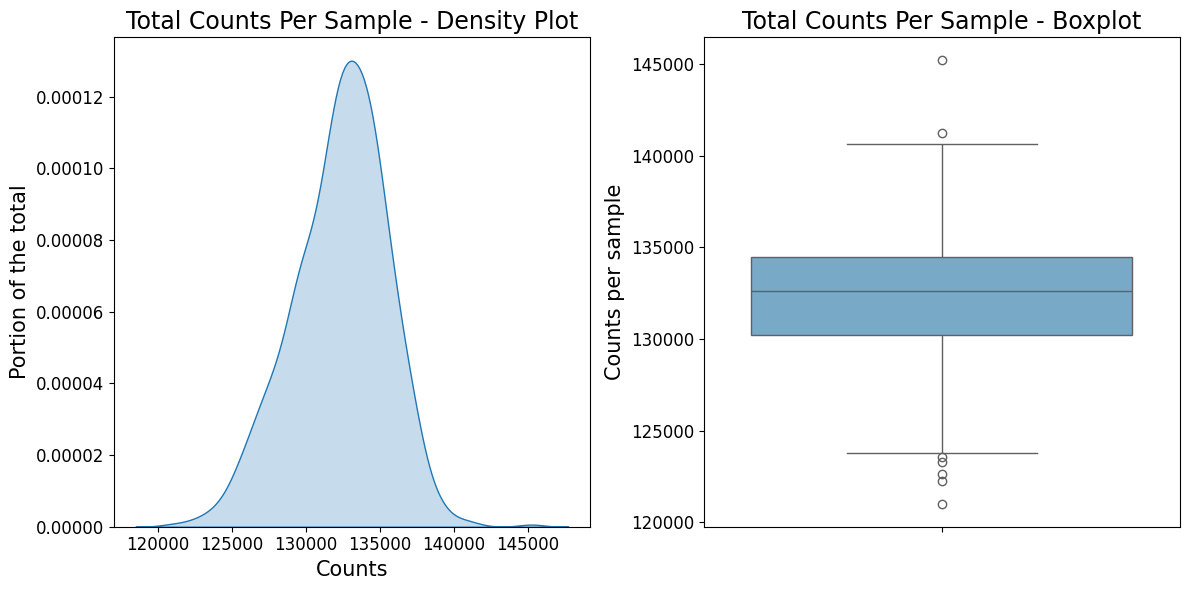

In [7]:
total_counts = data.sum(axis=1)

median_counts = data.median(axis=1)
mean_counts = data.mean(axis=1)
std_counts = data.std(axis=1)

total_counts_overall = total_counts.sum()
percent_reads_mapped = (total_counts / total_counts_overall) * 100

summary_stats = pd.DataFrame({
    "Total_Reads": total_counts,
    "Median_Reads": median_counts,
    "Mean_Reads": mean_counts,
    "Std_Dev_Reads": std_counts,
    "Percent_Reads_Mapped": percent_reads_mapped
})

summary_stats_sorted = summary_stats.sort_values(by=["Total_Reads"], axis=0, ascending=True)
display(summary_stats_sorted)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.kdeplot(x=summary_stats_sorted["Total_Reads"], fill=True, ax=axes[0])
axes[0].set_title("Total Counts Per Sample - Density Plot", fontsize=17)
axes[0].set_xlabel("Counts", fontsize=15)
axes[0].set_ylabel("Portion of the total", fontsize=15)
axes[0].tick_params(labelsize=12)
sns.boxplot(summary_stats_sorted["Total_Reads"], ax=axes[1], palette="Blues", orient="v")
axes[1].set_title("Total Counts Per Sample - Boxplot", fontsize=17)
axes[1].set_ylabel("Counts per sample", fontsize=15)
axes[1].tick_params(labelsize=12)

plt.tight_layout()
plt.show()

### Gene Expression Clustering

/home/eprdz/.local/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/eprdz/.local/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.02, 'Clustermap of Gene Expression by Cancer Types')

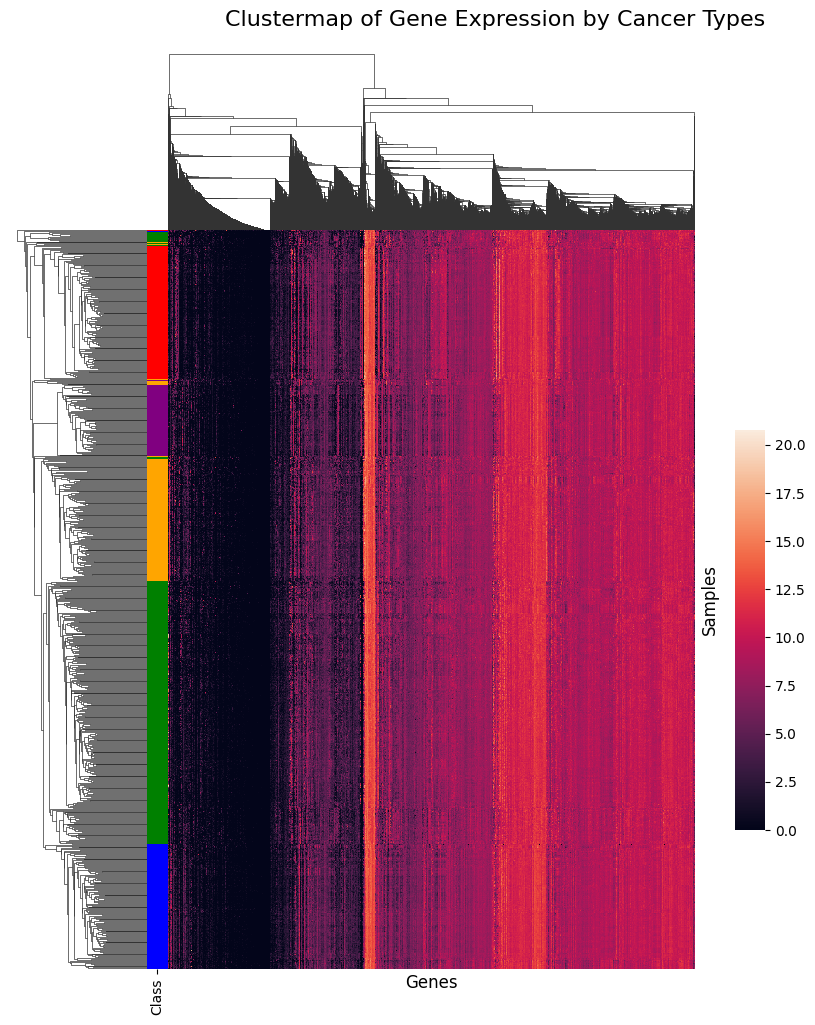

In [8]:
label_classes = labels["Class"].unique()

color_mapping = {'PRAD': 'blue', 'LUAD': 'orange', 'BRCA': 'green', 'KIRC': 'red', 'COAD': 'purple'} ## To keep reproducibility of colors

row_colors = labels.set_index("Unnamed: 0")["Class"].map(color_mapping)

g = sns.clustermap(data, row_colors = row_colors, xticklabels = False, yticklabels = False)
g.ax_heatmap.set_xlabel("Genes", fontsize=12)
g.ax_heatmap.set_ylabel("Samples", fontsize=12)
g.fig.subplots_adjust(right=0.7)
g.ax_cbar.set_position((0.74, .2, .03, .4))
g.fig.suptitle("Clustermap of Gene Expression by Cancer Types", fontsize=16, y=1.02)

## 2. Data Preprocessing
Definition of two classes that are normalizations that are going to be used in a Pipeline

In [9]:
class RelativeAbundance(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        row_sums = np.sum(X, axis=1, keepdims=True)  
        row_sums[row_sums == 0] = 1e-10  # Avoid division by zero
        return X / row_sums


In [10]:
class DESeq2(BaseEstimator, TransformerMixin): ## Transcriptomics-specific Normalization
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        logmeans, filtered_genes = deseq2_norm_fit(X)
        return deseq2_norm_transform(data, logmeans, filtered_genes)[0]

### Creation of a dictionary with the PCA coordinates to be plot after different types of normalization

In [11]:
datasets = {}
normalization_methods = {
    "No Normalization": FunctionTransformer(lambda x: x, validate=True),
    "Relative Abundance Normalization": RelativeAbundance(),
    "DESeq2": DESeq2(),
    "Log Ratio Normalization": FunctionTransformer(np.log1p, validate=True),
}

reduction_methods = {
    "PCA": PCA(n_components=2),
}

for norm_name, norm_transformer in normalization_methods.items():
    for red_name, red_transformer in reduction_methods.items():
        pipeline = Pipeline([
            ("normalization", norm_transformer),
            ("dim_reduction", red_transformer),
        ])

        # Fit-transform the data using the pipeline
        reduced_data = pipeline.fit_transform(data)
        datasets[norm_name] = {
            "data": reduced_data,
            "explained_variance_ratio": (
                red_transformer.explained_variance_ratio_
                if hasattr(red_transformer, "explained_variance_ratio_")
                else [0, 0]  # Placeholder for non-PCA methods
            ),
        }

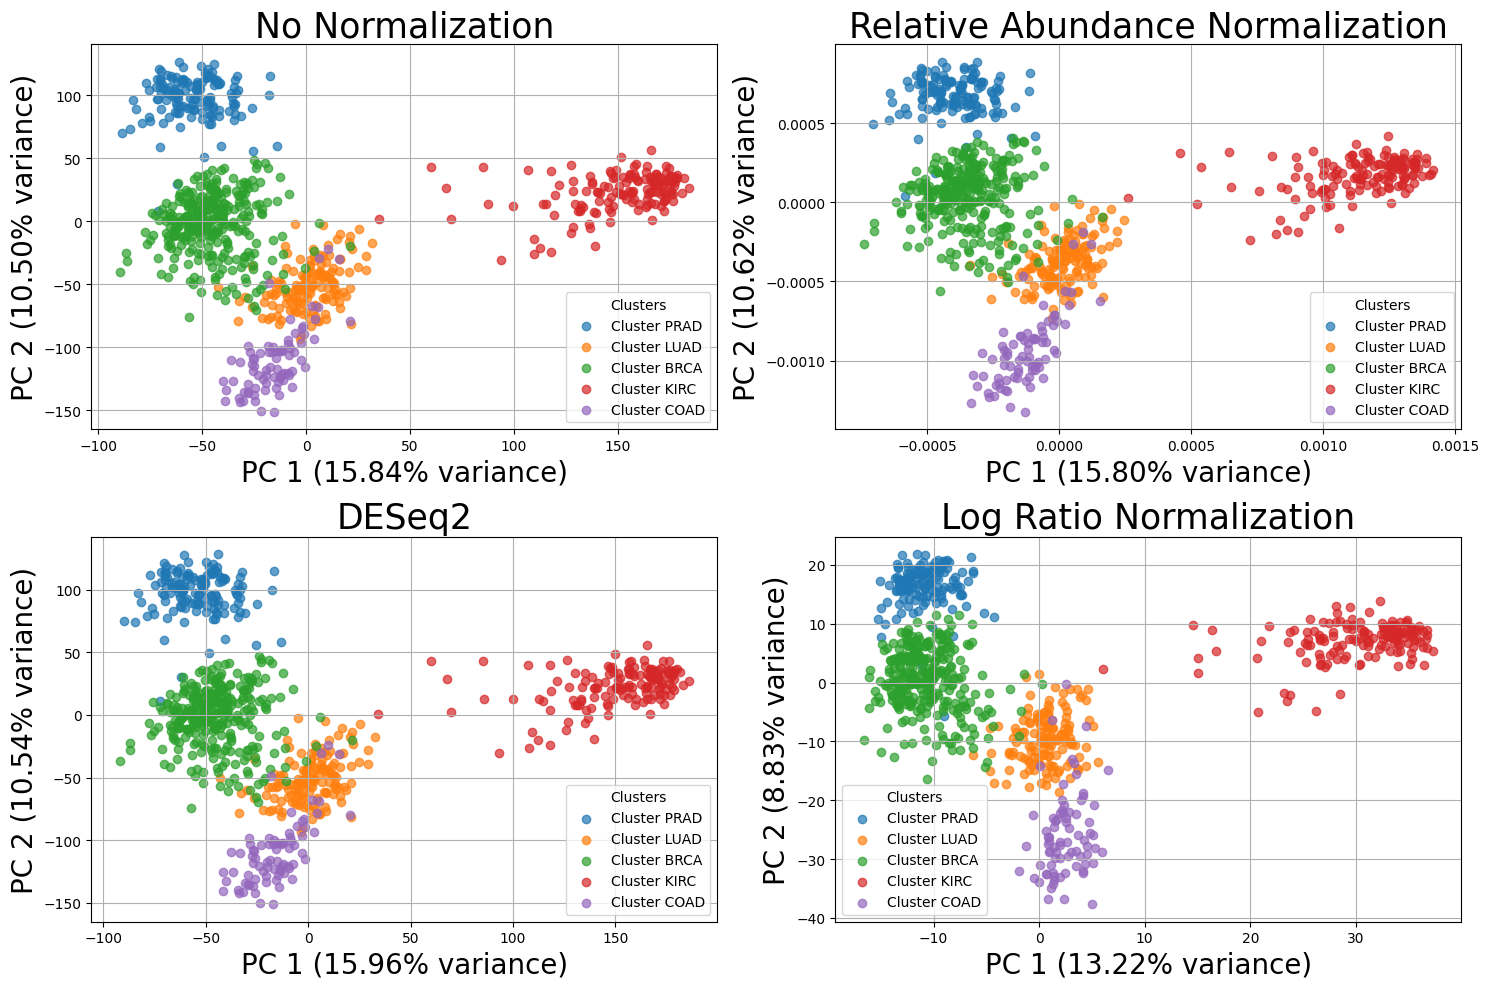

In [12]:
n_plots = len(datasets.keys())
n_cols = 2  
n_rows = (n_plots + 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, (key, value) in enumerate(datasets.items()):
    data_2d = pd.DataFrame(value["data"], columns=['PC1', 'PC2'])
    explained_variance_ratio = value["explained_variance_ratio"]

    if isinstance(labels, pd.DataFrame):
        labels_1d = labels.iloc[:, 1] 
    else:
        labels_1d = labels

    # Plot each dataset in its subplot
    ax = axes[i]
    unique_labels = pd.unique(labels_1d)

    for label in unique_labels:
        cluster_indices = labels_1d == label
        ax.scatter(data_2d.loc[cluster_indices, 'PC1'],
                   data_2d.loc[cluster_indices, 'PC2'],
                   label=f'Cluster {label}', alpha=0.7)

    pc1_variance = explained_variance_ratio[0] * 100
    pc2_variance = explained_variance_ratio[1] * 100

    ax.set_title(key, size = 25)
    ax.set_xlabel(f"PC 1 ({pc1_variance:.2f}% variance)", size = 20)
    ax.set_ylabel(f"PC 2 ({pc2_variance:.2f}% variance)", size = 20)
    ax.legend(title="Clusters")
    ax.grid()

for j in range(len(datasets), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### DESeq2 Normalization

In [13]:
logmeans, filtered_genes = deseq2_norm_fit(data)
deseq2 = deseq2_norm_transform(data, logmeans, filtered_genes)[0]

### Feature Selection - Selection of highly expressed and variable genes

/tmp/ipykernel_8774/2797570081.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_to_plot, x="Metric", y="Value", palette="Blues",  flierprops={"marker": "x", "markersize": "3"})


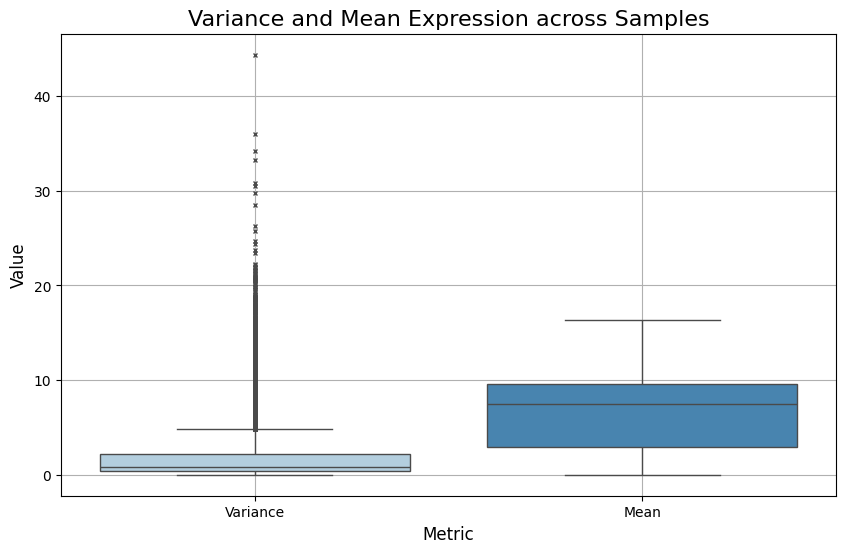

In [14]:
variance_counts = deseq2.var(axis=0)
mean_counts = deseq2.mean(axis=0)

import pandas as pd

data_to_plot = pd.DataFrame({
    "Variance": variance_counts,
    "Mean": mean_counts
}).melt(var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.boxplot(data=data_to_plot, x="Metric", y="Value", palette="Blues",  flierprops={"marker": "x", "markersize": "3"})

plt.title("Variance and Mean Expression across Samples", fontsize=16)
plt.xlabel("Metric", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid()
plt.show()


In [15]:
data_to_plot.groupby("Metric").describe()

Value                                                         \
            count      mean       std  min       25%       50%       75%   
Metric                                                                     
Mean      20531.0  6.415444  3.819034  0.0  2.923279  7.481718  9.531956   
Variance  20531.0  1.747324  2.554341  0.0  0.341730  0.793447  2.147609   

                     
                max  
Metric               
Mean      16.361231  
Variance  44.370580

In [16]:
filtered_genes = deseq2.loc[:,
    (variance_counts > 2.147609) & (mean_counts > 9.531956) ## Select values higher than the 3rd quartile
]

### Gene Expression Clustering in the final dataset that is going to be used

/home/eprdz/.local/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/eprdz/.local/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.02, 'Clustermap of Gene Expression by Cancer Types')

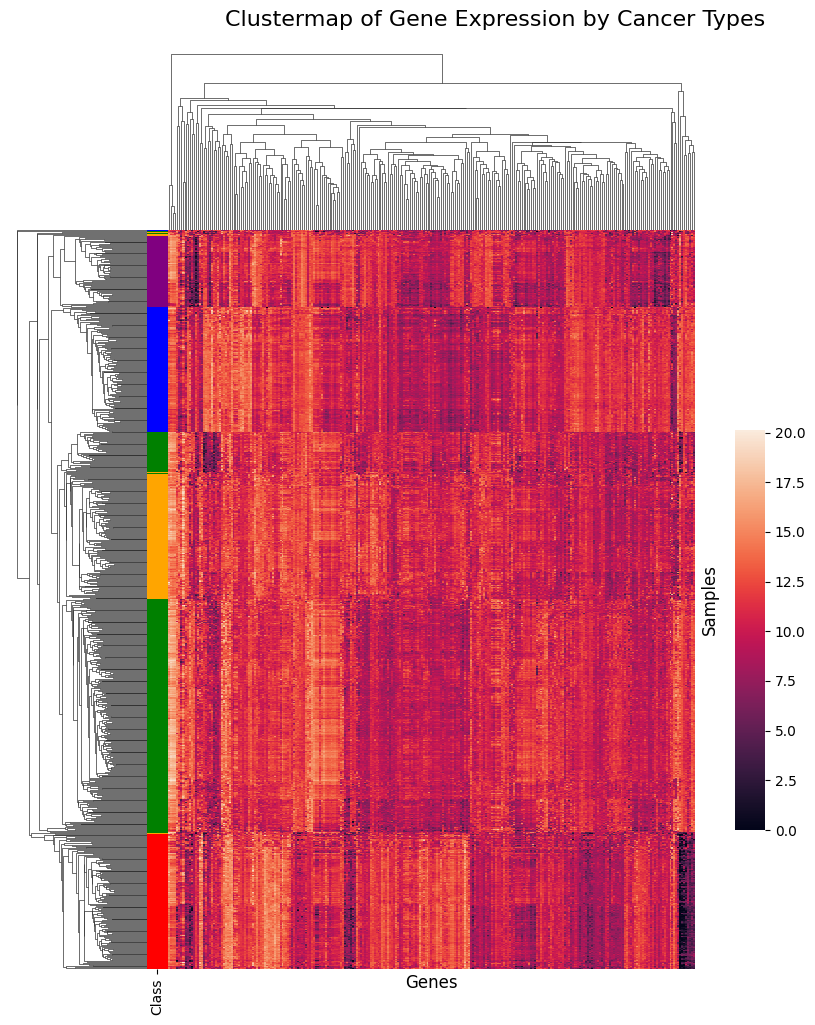

In [17]:
label_classes = labels["Class"].unique()

color_mapping = {'PRAD': 'blue', 'LUAD': 'orange', 'BRCA': 'green', 'KIRC': 'red', 'COAD': 'purple'}

row_colors = labels.set_index("Unnamed: 0")["Class"].map(color_mapping)

g = sns.clustermap(filtered_genes, row_colors = row_colors, xticklabels = False, yticklabels = False)
g.ax_heatmap.set_xlabel("Genes", fontsize=12)
g.ax_heatmap.set_ylabel("Samples", fontsize=12)
g.fig.subplots_adjust(right=0.7)
g.ax_cbar.set_position((0.74, .2, .03, .4))
g.fig.suptitle("Clustermap of Gene Expression by Cancer Types", fontsize=16, y=1.02)

## 3. Machine Learning Modelling and Prediction

### SMOTE and SVM

In [18]:
oversample = SMOTE(random_state=123)
X, y = oversample.fit_resample(filtered_genes, labels.Class)


/home/eprdz/.local/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/eprdz/.local/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


/tmp/ipykernel_8774/561456734.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


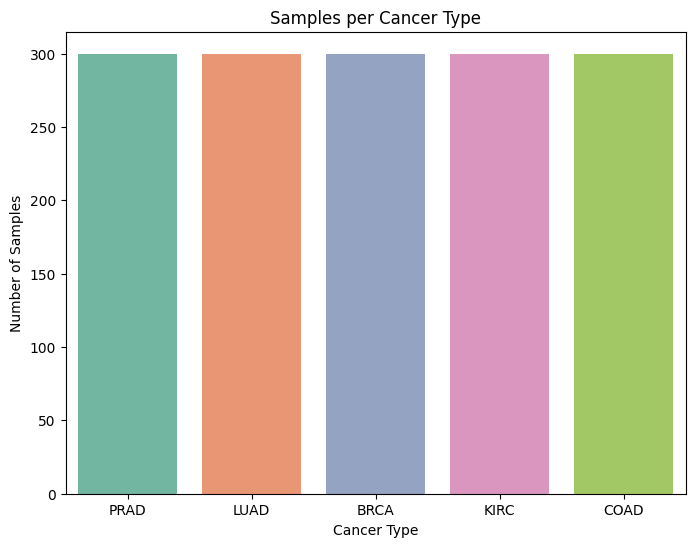

In [19]:
class_counts = y.value_counts()
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    x=class_counts.index,
    y=class_counts.values,
    palette="Set2",
    legend="fds"
)
ax.set(xlabel = "Cancer Type", ylabel='Number of Samples', title = "Samples per Cancer Type")
plt.show()

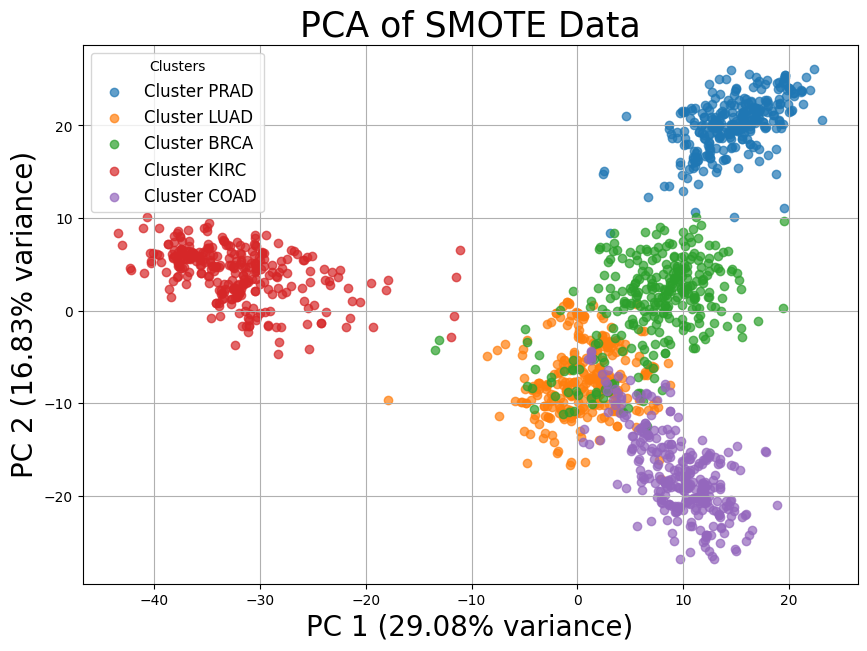

In [20]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X)
pca_df = pd.DataFrame(data=reduced_data, columns=['PC1', 'PC2'])
pca_df['Label'] = y

unique_labels = pd.unique(y)

plt.figure(figsize=(10, 7))
for label in unique_labels:
    cluster_indices = pca_df['Label'] == label
    plt.scatter(pca_df.loc[cluster_indices, 'PC1'],
                pca_df.loc[cluster_indices, 'PC2'],
                label=f'Cluster {label}', alpha=0.7)

pc1_variance = pca.explained_variance_ratio_[0] * 100
pc2_variance = pca.explained_variance_ratio_[1] * 100

plt.title("PCA of SMOTE Data", size=25)
plt.xlabel(f"PC 1 ({pc1_variance:.2f}% variance)", size=20)
plt.ylabel(f"PC 2 ({pc2_variance:.2f}% variance)", size=20)
plt.legend(title="Clusters", fontsize=12)
plt.grid()
plt.show()

### Training the Model

In [21]:
X_scale = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, random_state=123)

svc = SVC(random_state=123)
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ["poly", "rbf", "sigmoid"],
    'degree' : [2, 3, 4, 5],
    "gamma": ["scale", "auto"],
    "decision_function_shape": ["ovo", "ovr"]
}

grid_search_svc = GridSearchCV(estimator= svc,                               
                           param_grid=params, 
                           cv=4, scoring = ['accuracy'], refit='accuracy')

grid_search_svc.fit(X_train, y_train)
results_svc = pd.DataFrame(grid_search_svc.cv_results_)
sorted_results_svc = results_svc.sort_values(by='mean_test_accuracy', ascending=False).head(5)
print(sorted_results_svc)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
143       0.018530      0.000172         0.006779        0.000041      0.1   
110       0.019149      0.000302         0.006979        0.000181      0.1   
125       0.018611      0.000263         0.006809        0.000056      0.1   
131       0.018567      0.000289         0.006795        0.000065      0.1   
134       0.019028      0.000205         0.006867        0.000072      0.1   

    param_decision_function_shape  param_degree param_gamma param_kernel  \
143                           ovr             5        auto      sigmoid   
110                           ovo             4       scale      sigmoid   
125                           ovr             2        auto      sigmoid   
131                           ovr             3        auto      sigmoid   
134                           ovr             4       scale      sigmoid   

                                                params  split0_test_accura

In [22]:
results_svc.sort_values(by='mean_test_accuracy', ascending=False).to_csv("results_svc.csv", sep=",", index=False)

In [23]:
best_svc = grid_search_svc.best_estimator_.fit(X_train, y_train)

### Metrics

In [24]:
accuracy_score(y_test, best_svc.predict(X_test))

0.9973333333333333

In [25]:
f1_score(y_test, best_svc.predict(X_test), average="weighted")

0.9973339110591158

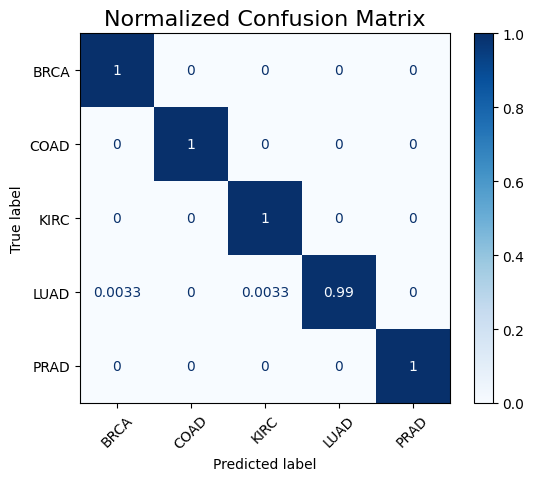

In [26]:
cm = confusion_matrix(y, best_svc.predict(X_scale), normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svc.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Normalized Confusion Matrix", fontsize=16)
plt.show()

### Balanced Random Forest Classifier

In [27]:
warnings.filterwarnings('ignore')

data_train, data_test, labels_train, labels_test = train_test_split(filtered_genes, labels.Class, random_state=123, stratify=labels.Class)

params = {
    'n_estimators' : [50,100,150,200,250],
    'max_depth': [2, 3, 5, 10, 20],
    'bootstrap': [True, False],
    'min_samples_leaf' : [3,10,30],
    'criterion': ["gini", "entropy"]
}

scoring_metrics = ['accuracy']

grid_search_rf = GridSearchCV(estimator=BalancedRandomForestClassifier(random_state=123), param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search_rf.fit(data_train, labels_train)

results_rf = pd.DataFrame(grid_search_rf.cv_results_)
display(results_rf)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,0.099288,0.003787,0.005509,0.000135,True,gini,2,3,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.980000,0.973333,0.980000,0.986667,0.980000,0.004714,268
1,0.184016,0.001664,0.007880,0.000036,True,gini,2,3,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.973333,0.980000,0.973333,0.986667,0.978333,0.005528,282
2,0.272163,0.000847,0.010634,0.000089,True,gini,2,3,150,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.986667,0.980000,0.973333,0.986667,0.981667,0.005528,242
3,0.359938,0.004294,0.013305,0.000062,True,gini,2,3,200,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.980000,0.986667,0.986667,1.000000,0.988333,0.007265,128
4,0.451293,0.002669,0.016093,0.000210,True,gini,2,3,250,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.980000,0.980000,0.993333,0.986667,0.985000,0.005528,207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.109773,0.001090,0.005186,0.000056,False,entropy,20,30,50,"{'bootstrap': False, 'criterion': 'entropy', '...",0.973333,0.980000,1.000000,0.993333,0.986667,0.010541,193
296,0.213774,0.001856,0.007901,0.000120,False,entropy,20,30,100,"{'bootstrap': False, 'criterion': 'entropy', '...",0.980000,0.986667,0.993333,0.986667,0.986667,0.004714,169
297,0.332559,0.010414,0.011183,0.000509,False,entropy,20,30,150,"{'bootstrap': False, 'criterion': 'entropy', '...",0.980000,0.986667,0.993333,0.986667,0.986667,0.004714,169
298,0.426306,0.002964,0.013551,0.000235,False,entropy,20,30,200,"{'bootstrap': False, 'criterion': 'entropy', '...",0.980000,0.993333,0.993333,0.993333,0.990000,0.005774,122


In [28]:
results_rf.sort_values(by='mean_test_accuracy', ascending=False).to_csv("results_rf.csv", sep=",", index=False)

In [29]:
brf = BalancedRandomForestClassifier(bootstrap=True, criterion='entropy', max_depth=5, min_samples_leaf= 3, n_estimators= 150, random_state=123).fit(data_train, labels_train)
accuracy_score(y_pred=brf.predict(data_test), y_true=labels_test)

0.9950248756218906

### Gini Importance

In [30]:
importances = brf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': filtered_genes.columns, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
display(feature_imp_df)

,Feature,Gini Importance
261,gene_18746,0.042168
93,gene_6593,0.039899
219,gene_16338,0.031638
59,gene_4224,0.029366
236,gene_17376,0.028722
...,...,...
181,gene_13543,0.000000
208,gene_15724,0.000000
54,gene_4061,0.000000
228,gene_16527,0.000000


In [31]:
sum(feature_imp_df["Gini Importance"][0:10])

0.2785889708906577

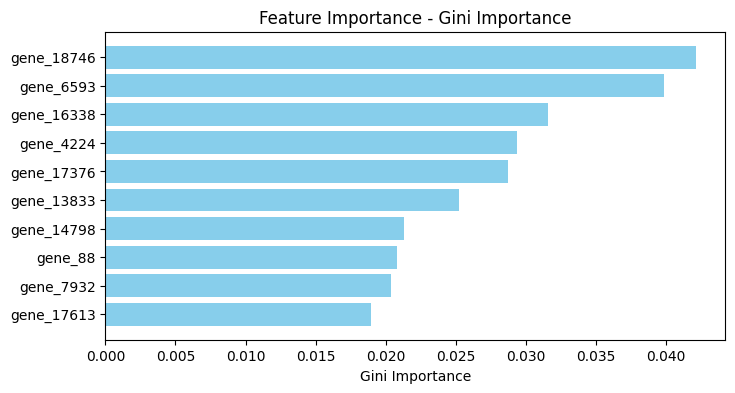

In [32]:
plt.figure(figsize=(8, 4))
plt.barh(feature_imp_df.Feature[0:10], feature_imp_df["Gini Importance"][0:10], color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

### SHAP Values

In [33]:
explainer = shap.TreeExplainer(brf, filtered_genes)
shap_values = explainer(filtered_genes)

 95%|=================== | 3793/4005 [00:11<00:00]       

In [34]:
brf.classes_

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype=object)

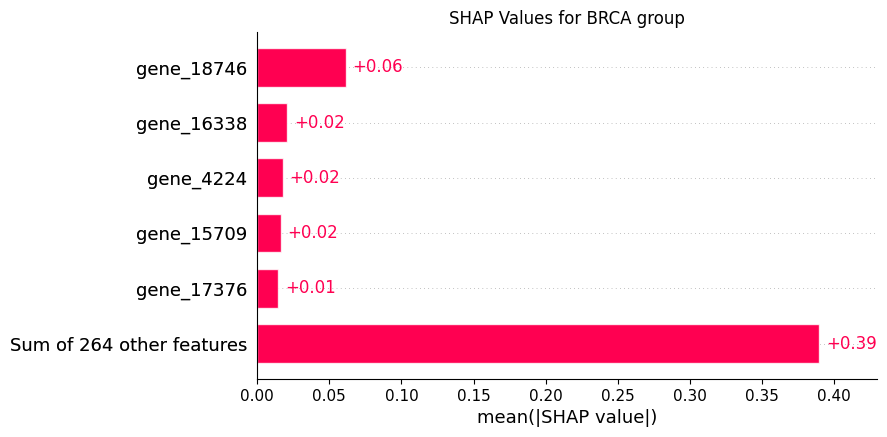

In [35]:
ax = shap.plots.bar(shap_values[:, :, 0], max_display=6, show=False)
ax.set_title("SHAP Values for BRCA group")
plt.show()

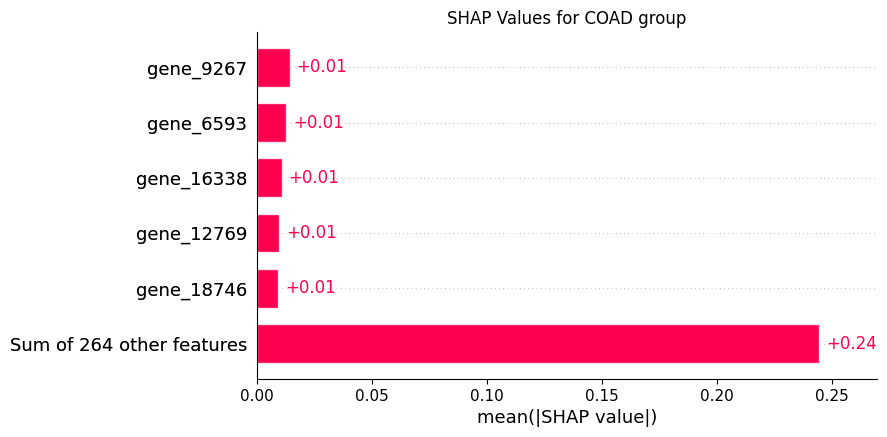

In [36]:
ax = shap.plots.bar(shap_values[:, :, 1], max_display=6, show=False)
ax.set_title("SHAP Values for COAD group")
plt.show()

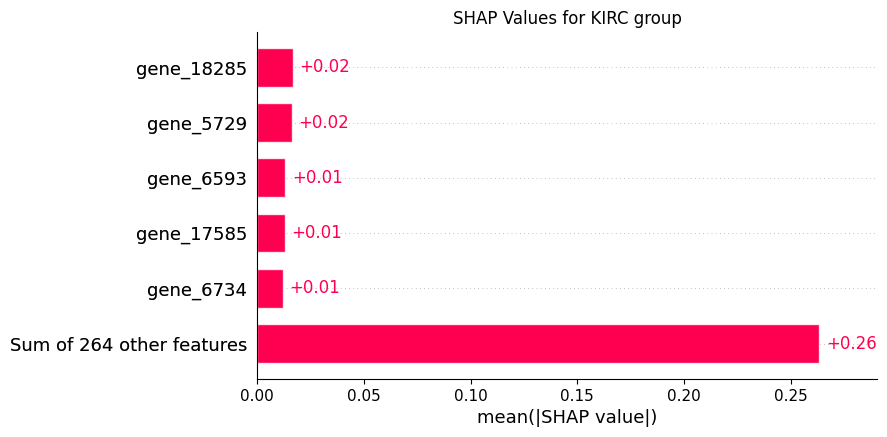

In [37]:
ax = shap.plots.bar(shap_values[:, :, 2], max_display=6, show=False)
ax.set_title("SHAP Values for KIRC group")
plt.show()

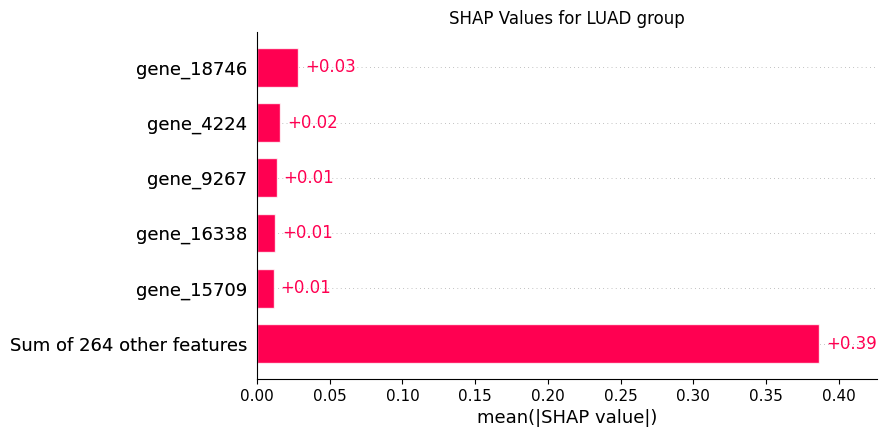

In [38]:
ax = shap.plots.bar(shap_values[:, :, 3], max_display=6, show=False)
ax.set_title("SHAP Values for LUAD group")
plt.show()

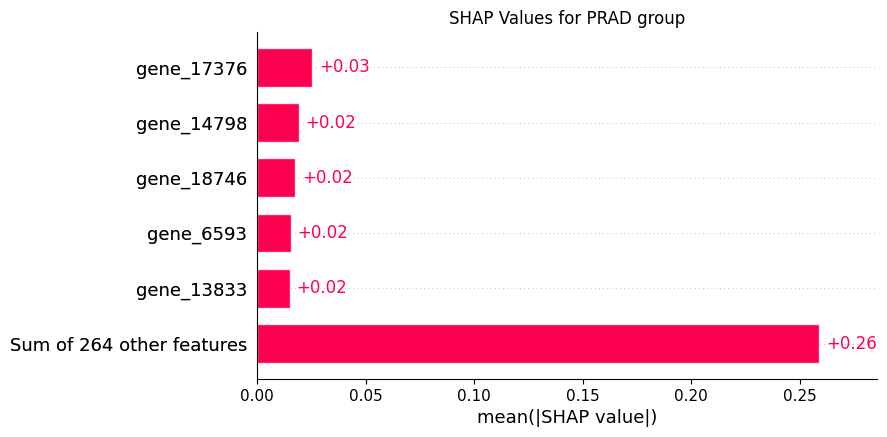

In [39]:

ax = shap.plots.bar(shap_values[:, :, 4], max_display=6, show=False)
ax.set_title("SHAP Values for PRAD group")
plt.show()

### Plots of the expression of Biomarkers

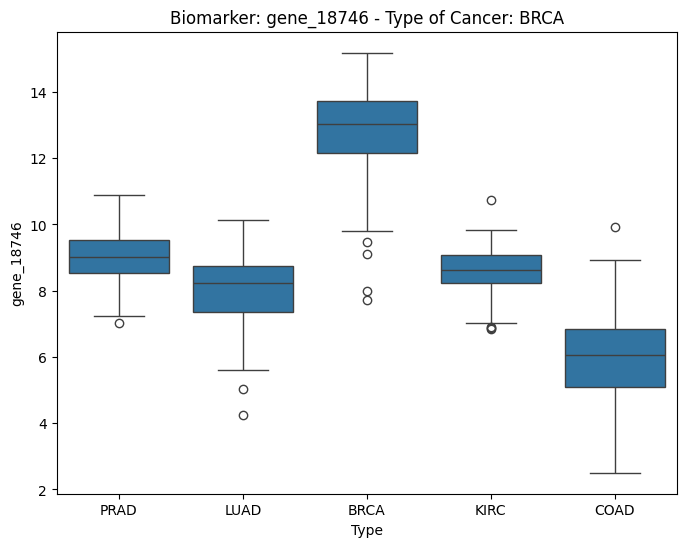

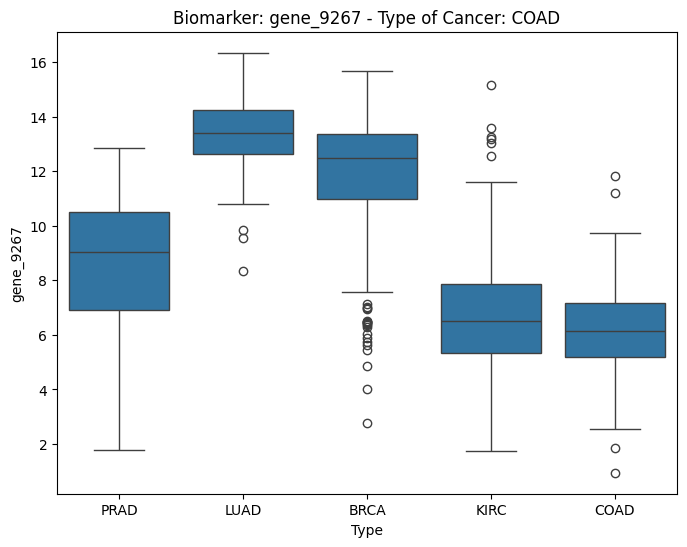

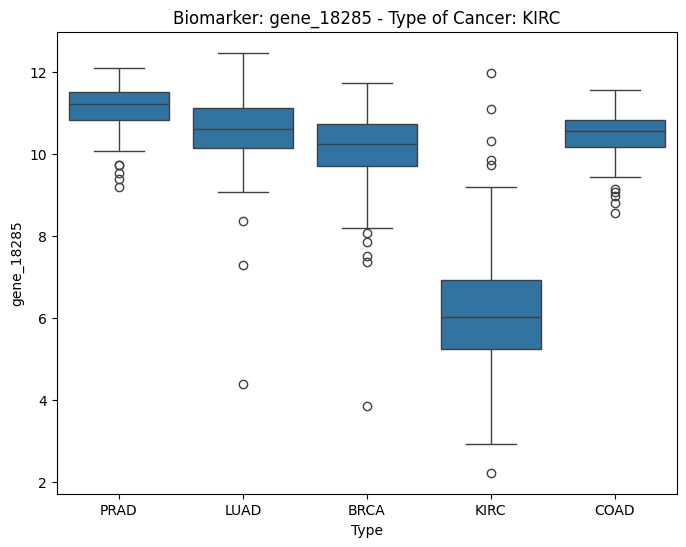

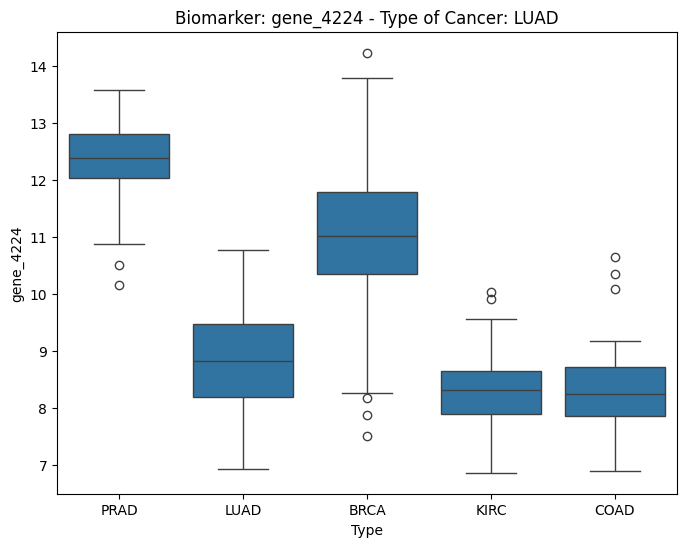

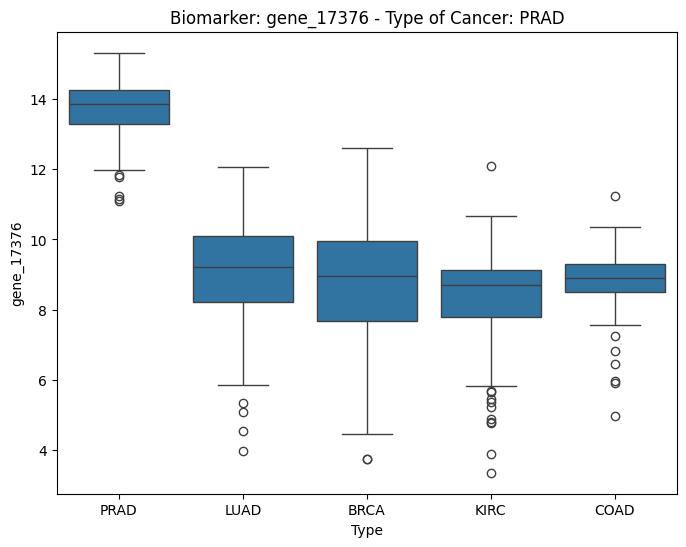

In [40]:
genes_to_analyse = {"BRCA": "gene_18746", "COAD": "gene_9267", "KIRC": "gene_18285", "LUAD": "gene_4224", "PRAD": "gene_17376"}
filtered_genes["Type"] = pd.Series(labels.Class.values, index=filtered_genes.index)
for sample, gene in genes_to_analyse.items():
    plt.figure(figsize=(8, 6))  # Create a new figure for each plot
    sns.boxplot(x="Type", y=gene, data=filtered_genes)
    plt.title(f"Biomarker: {gene} - Type of Cancer: {sample}")
    plt.savefig(sample)

## 4. Deep Learning Modelling and Prediction

### Model Design

In [41]:
keras.utils.set_random_seed(123)
model = tf.keras.models.Sequential(name="RNA-Seq_NN")
norm =  tf.keras.layers.Normalization(
    axis=-1
)
kerner_regularizer_l2 = regularizers.l2(5e-4)
model.add(keras.layers.Input(shape=(269,)))
model.add(norm)
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=kerner_regularizer_l2))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(5, activation='softmax'))

2025-02-09 21:28:22.901624: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [42]:
model.summary()

Model: "RNA-Seq_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 269)              539       
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                8640      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 16)                5

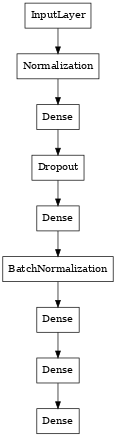

In [43]:
plot_model(model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=50,
    show_layer_activations=False,
    show_trainable=False
)

### Traning the Model

Epoch 1/50
19/19 [==============================] - 1s 19ms/step - loss: 1.5836 - accuracy: 0.3083 - val_loss: 1.6935 - val_accuracy: 0.1692
Epoch 2/50
19/19 [==============================] - 0s 7ms/step - loss: 1.4617 - accuracy: 0.3867 - val_loss: 1.5318 - val_accuracy: 0.3731
Epoch 3/50
19/19 [==============================] - 0s 6ms/step - loss: 1.4025 - accuracy: 0.3917 - val_loss: 1.2228 - val_accuracy: 0.5323
Epoch 4/50
19/19 [==============================] - 0s 6ms/step - loss: 1.3086 - accuracy: 0.4183 - val_loss: 1.2742 - val_accuracy: 0.3781
Epoch 5/50
19/19 [==============================] - 0s 12ms/step - loss: 1.1412 - accuracy: 0.4783 - val_loss: 1.2011 - val_accuracy: 0.4378
Epoch 6/50
19/19 [==============================] - 0s 7ms/step - loss: 1.0947 - accuracy: 0.5150 - val_loss: 1.2344 - val_accuracy: 0.5075
Epoch 7/50
19/19 [==============================] - 0s 7ms/step - loss: 0.9894 - accuracy: 0.6217 - val_loss: 1.0408 - val_accuracy: 0.7711
Epoch 8/50
19/19 [

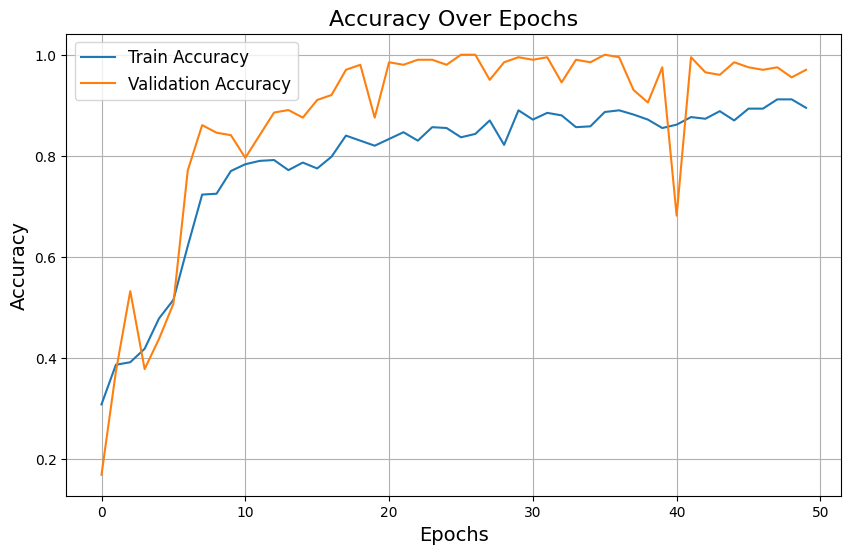

In [44]:
# Convert labels to one-hot encoding
le = preprocessing.LabelEncoder()
labels_train_ohe = to_categorical(le.fit_transform(labels_train), num_classes=5)
labels_test_ohe = to_categorical(le.fit_transform(labels_test), num_classes=5)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming you have trained your model and saved the history
history = model.fit(
    data_train, labels_train_ohe,
    validation_data=(data_test, labels_test_ohe),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


### Reducing the Dropout

In [45]:
keras.utils.set_random_seed(123)
model = tf.keras.models.Sequential(name="RNA-Seq_NN_Dropout_5")
norm =  tf.keras.layers.Normalization(
    axis=-1
)
kerner_regularizer_l2 = regularizers.l2(5e-4)
model.add(keras.layers.Input(shape=(269,)))
model.add(norm)
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(rate=0.05))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=kerner_regularizer_l2))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(5, activation='softmax'))

Epoch 1/50
19/19 [==============================] - 1s 15ms/step - loss: 1.4679 - accuracy: 0.4300 - val_loss: 1.9330 - val_accuracy: 0.1542
Epoch 2/50
19/19 [==============================] - 0s 8ms/step - loss: 1.2778 - accuracy: 0.4883 - val_loss: 1.1064 - val_accuracy: 0.5224
Epoch 3/50
19/19 [==============================] - 0s 7ms/step - loss: 1.0822 - accuracy: 0.5583 - val_loss: 0.9016 - val_accuracy: 0.5970
Epoch 4/50
19/19 [==============================] - 0s 7ms/step - loss: 0.9517 - accuracy: 0.6850 - val_loss: 0.8520 - val_accuracy: 0.7264
Epoch 5/50
19/19 [==============================] - 0s 7ms/step - loss: 0.7957 - accuracy: 0.7833 - val_loss: 0.7712 - val_accuracy: 0.7065
Epoch 6/50
19/19 [==============================] - 0s 8ms/step - loss: 0.6727 - accuracy: 0.8800 - val_loss: 0.6127 - val_accuracy: 0.8159
Epoch 7/50
19/19 [==============================] - 0s 7ms/step - loss: 0.5225 - accuracy: 0.9067 - val_loss: 0.4969 - val_accuracy: 0.8209
Epoch 8/50
19/19 [=

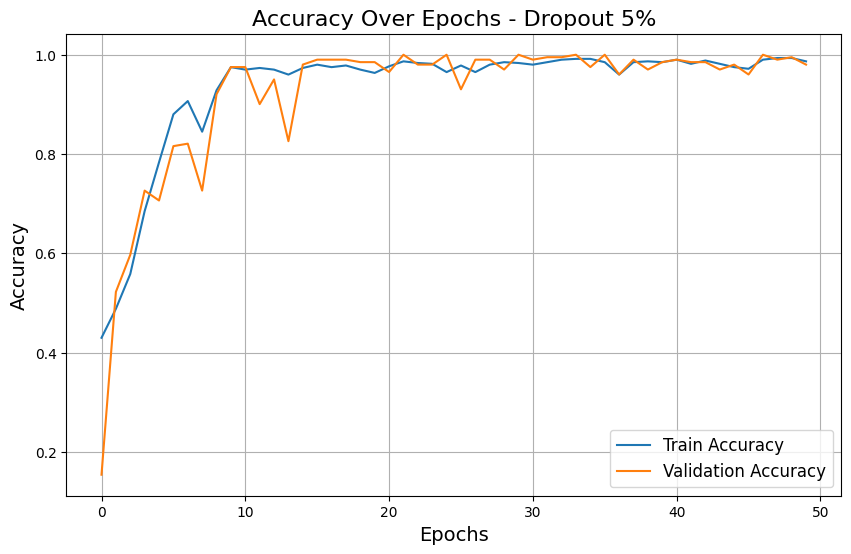

In [46]:
# Convert labels to one-hot encoding
le = preprocessing.LabelEncoder()
labels_train_ohe = to_categorical(le.fit_transform(labels_train), num_classes=5)
labels_test_ohe = to_categorical(le.fit_transform(labels_test), num_classes=5)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming you have trained your model and saved the history
history = model.fit(
    data_train, labels_train_ohe,
    validation_data=(data_test, labels_test_ohe),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs - Dropout 5%', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()
